Using PINNs to solve the diffusion equation with Dirichlet boundary conditions

## **Setup**

In [1]:
# Set matplotlib for inline plots
%matplotlib inline
# Set matplotlib default font size\n",
import matplotlib as mpl
mpl.rc('font', size=15)
# Imports
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## **PyTorch Functions**

In [2]:
"""
Fully connected feed-forward neural network 
"""

class FCN(nn.Module):
    
    def __init__(self, N_in, N_out, N_h, activation='tanh'):
        super().__init__()
        
        # Save network parameters
        self.N_in = N_in
        self.N_out = N_out
        # Hidden layer size may be int or list of ints
        if isinstance(N_h, int):
            self.N_h = [N_h]
        else:
            self.N_h = N_h
        self.N_layers = len(self.N_h)
        
        # Select the activation function
        if activation == 'tanh':
            activation = nn.Tanh
        elif activation == 'relu':
            activation = nn.ReLU
        elif activation == 'sine':
            activation = torch.sin
        
        # Create the layers
        self.fcs = nn.Sequential(*[
            nn.Linear(N_in, self.N_h[0]), 
            activation()
        ])
        self.fch = nn.Sequential(*[
            nn.Sequential(*[
                nn.Linear(self.N_h[i], self.N_h[i+1]),
                activation()
            ]) 
            for i in range(self.N_layers-1)]
        )
        self.fce = nn.Linear(self.N_h[-1], N_out)
        
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [3]:
"""
Quick test of the network class
"""
# Create a network
NN = FCN(N_in=2, N_out=1, N_h=[16,16])
# Create a random input
s = torch.rand(size=(10,2))
# Compute the network's output
NN_s = NN(s)
print(NN_s.shape)

torch.Size([10, 1])


In [4]:
"""
Functions for computing derivatives of the network's output wrt its input
"""

def compute_u_v(v, u):
    """
    Computes u_v for the independent variable v and dependent variable u
    """
    return torch.autograd.grad(u, v, torch.ones_like(u), create_graph=True)[0]


def compute_u_vv(v, u_v):
    """
    Computes u_vv for the independent variable 'v' and dependent variable 'u' (not a parameter here)
    Must be given u_v, the partial derivative computed using compute_u_v()
    """
    return torch.autograd.grad(u_v, v, torch.ones_like(u_v), create_graph=True)[0]

## **Mesh Functions**

In [2]:
"""
Function to generate mesh points on [0,1]^d x [0,T]
"""
def generate_mesh(nt, nx, d=1, T=1):
    """
     ARGUMENTS
        
        nt, nx   :   Ints. Number of temporal and spatial interior points
                     for the mesh, respectively
                     
        d        :   Int. Spatial dimension
        
        T        :   Float. Sets time domain to [0,T]
                     Default: 1
    
    RETURNS
    
        mesh_interior     :   (nt * nx^d, d+1)- Torch array of the interior of 
                                the spatiotemporal mesh (t != 0 and x_i \notin {0,1}
                                for all i)
                                
        mesh_boundary     :   (???, d+1) - Torch array of the spatial boundary
                                of the spatiotemporal mesh (x_i = 0 or x_i = 1
                                for some i = 1, ..., d)
                                
        mesh_t0           :   (nx*d, d+1)- Torch array of the t=0 mesh points
    """
    t_vals = torch.linspace(0,T,steps=nt+2)
    x_vals = torch.linspace(0,1,steps=nx+2)
    
    # Create the mesh using meshgrid
    mesh = torch.vstack([
        mesh_dim.ravel() 
        for mesh_dim in torch.meshgrid(
            [t_vals] + [x_vals] * d,
            indexing='ij'
        )
    ])
    
    # Return
    return mesh.t()


# TODO: implement - takes (# points, d+1) mesh and 
# converts it to (# timesteps, # space steps, ..., # space steps) tensor 
# def reshape_mesh()

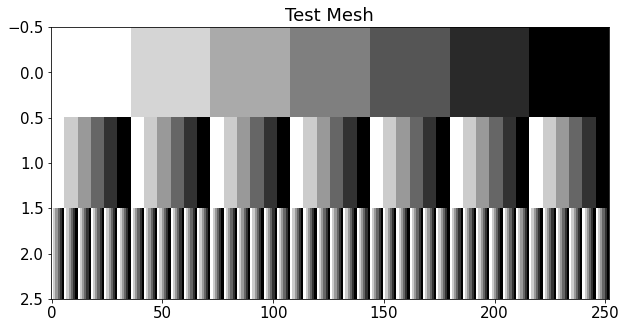

In [3]:
test_mesh = generate_mesh(5, 4, d=2)

plt.figure(figsize=(10,5))
plt.title('Test Mesh')
plt.imshow(test_mesh.T, cmap='binary',aspect='auto', interpolation='none')
plt.show()

Maybe the generate_mesh function should return three elements:
- Interior mesh points
- Spatial boundary mesh points
- Initial time mesh points

That's not a bad plan. What would these pieces be called?
- mesh_interior
- mesh_boundary
- mesh_t0

Sure, that sounds like a good idea. 

The one issue I have now is that this mesh will get **very large** as we decrease the mesh size and dimension. For large $d$ values, we likely will not want to store the entire mesh in memory. We probably don't even want to have the loss at all mesh points computed for each parameter update; instead, we will select a sample of the mesh on which to compute the parameter gradient.

This is an interesting comment, because it kind of does away with the concept of a mesh for the neural network. We can literally just randomly sample points on the interior, boundaries, and $t = 0$, and this sampling doesn't have to make any reference to a mesh size.

This will be a different approach than the others in the group are taking, so let's try it out. Might be interesting to see if it works.

In [7]:
"""
Exact solution of the Fourier modes
for x in [-0.5,0.5]^d and t in [0,T]

u(x,t) = Imag( exp(-pi^2 |k|^2 - i k (x+1/2)) )
"""
def fourier_mode(n_t, n_x, k, T=1):
    """
    ARGUMENTS
        
        nt, nx   :   Ints. Number of temporal and spatial interior points
                     for the mesh, respectively
        
        k        :   (d,)-numpy array or list. Wave number of the mode
        
        T        :   Float. Sets time domain to [0,T]
    
    RETURNS
    
        u_fourier :  (# timesteps, # spatial steps, ..., # spatial steps)
                     Torch array of the exact solution for Fourier mode of
                     wave number k. The dimension of this array will be
                     d+1 where d is the spatial dimension set by wave number 
                     k   
    """
    # Determine the dimension
    d = len(k)
    
    # Mesh points in the time and space dimensions
    t_vals = torch.linspace(0,T,steps=nt+2)
    x_vals = torch.linspace(0,1,steps=nx+2)
    mesh = torch.meshgrid([t_vals] + [x_vals for _ in range(d)])
    
    # Exact solution of the Fourier mode
    undamped_soln = torch.product(
        [torch.sin(k[i] * torch.pi * mesh[i+1]) for i in range(d)]
    )
    lam = (torch.pi ** 2) * sum([k_i**2 for k_i in k])
    u = np.exp(-lam * mesh[0]) * undamped_soln

## **Mesh-Free Training Algorithm**

In [6]:
"""
Functions for randomly sampling the spatiotemporal domain

TODO (future): add option to control sampling distribution
"""

def sample_t0_points(n_pts, d, T=1):
    """
    Samples 'n_pts' points (t_i, x_i) from {0} x [0,1]^d
    where each x_ij ~ U([0,1])
    """
    points = torch.rand(size=(n_pts,d+1))
    points[:,0] = 0 # set time dimension to zero
    return points


def sample_boundary_points(n_pts, d, T=1):
    """
    Samples 'n_pts' points (t_i, x_i) from the spactial 
    boundary of [0,T] x [0,1]^d. In particular,
    
        t_i  ~ U(0,T),
        x_ij ~ U(0,1), and 
        x_ij = 0 or 1 for one randomly selected j
    """
    points = torch.rand(size=(n_pts,d+1))
    # Randomly select a spatial index to be set to 
    # 0 or 1 to enforce that this point is on the boundary
    bndy_inds = torch.randint(low=1,high=d+1,size=(n_pts,))
    bndy_vals = torch.randint(low=0,high=2,size=(n_pts,))
    points[torch.arange(n_pts),bndy_inds] = bndy_vals.float()
    # Rescale time
    points[:,0] *= T
    return points

def sample_interior_points(n_pts, d, T=1):
    """
    Samples 'n_pts' points (t_i, x_i) from (0,T) x (0,1)^d
    with t_i  ~ U(0,T) and x_ij ~ U(0,1)
    """
    points = torch.rand(size=(n_pts,d+1))
    points[:,0] *= T  # Rescale time
    return points

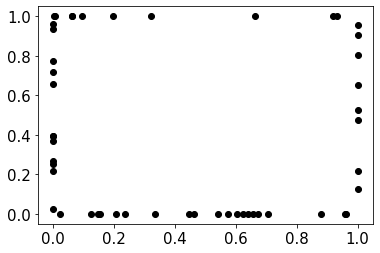

In [9]:
with torch.no_grad():
    bndy_points = sample_boundary_points(50, 2) 
    plt.scatter(bndy_points[:,1], bndy_points[:,2], c='k')
    plt.show()

In [7]:
"""
Mesh-free training algorithm
"""
def train_mesh_free(network,
        f_pde, f_bc, f_ic, n_pde_pts=None, n_bc_pts=None, n_ic_pts=None,
        alpha=None, n_iters=1000, lr=1e-3, verbose=None, u_exact=None
    ):
    """
    ARGUMENTS
    
        network      :  FCN network to be trained
        
        f_pde        :  Callable. Function that computes the partial derivative based 
                        quantity that should be minimized
                        
        f_bc         :  Callable. Function that computes the boundary conditions 
                        for the PDE that the NN is being trained to solve
        
        f_ic         :  Callable. Function that computes the initial condition 
                        for the PDE that the NN is being trained to solve
        
        n_pde_pts    :  Number of interior mesh points used to compute
                        the PDE loss on each iteration
                        Default: 2^(d+1), where d is # of spatial dimensions
        
        n_bc_pts     :  Number of boundary points used to compute the 
                        boundary condition loss on each iterations
                        Default: 2^d
        
        n_ic_pts     :  Number of points used to the compute the initial
                        condition loss on each iterations
                        Default: 2^d
                        
        alpha        :  3-tuple. Sets the scaling of the three
                        terms in the loss function
                        
                        L = alpha[0] L_pde + alpha[1] L_bc + alpha[2] * L_ic

                        Default: [1,1,1]
        
        n_iters      :  Number of training iterations
                        Default: 1000
                        
        lr           :  Learning rate
                        Default: 1e-3
        
        eps_term     :  Float. Train look terminates early if training loss drops below
                        this threshold
                        Default=0.0 (don't break)
        
        u_exact      :  None or Callable function that computes the exact
                        solution given any point in the domain
                        Default: None
    
    RETURNS
    
        L_pde
        
        L_bc
        
        L_ic
        
        L_train
        
        L2_err
    """
    
    # Parameter parsing
    # Spatial dimension
    d = network.N_in - 1
    # Number of pde / boundary/ t0 training points
    if n_pde_pts is None:
        n_pde_pts = 2 ** (d+1)
    if n_bc_pts is None:
        n_bc_pts = 2 ** d
    if n_ic_pts is None:
        n_ic_pts = 2 ** d
    
    # Loss coefs alpha[i]
    if alpha is None:
        alpha = [1,1,1]
    alpha = np.array(alpha, dtype=float)
    
    # Create the optimizer
    optimizer = torch.optim.Adam(network.parameters(),lr=lr)
    
    # Object to compute MSE loss
    mse_loss = nn.MSELoss()
    
    # Arrays to store the losses
    L_pde = np.zeros(n_iters)    # PDE loss
    L_bc = np.zeros(n_iters)     # Boundary condition loss
    L_ic = np.zeros(n_iters)     # Initial condition loss
    L_train = np.zeros(n_iters)  # Overall training loss
    if u_exact is not None:
        L2_err = np.zeros(n_iters)  # L2-error on exact solution

    # Training loop
    # TODO: make this a tqdm loop
    for i in range(n_iters):
        # Clear the parameter gradients
        optimizer.zero_grad()
        
        # Initial condition loss
        # Generate 'n_ic_pts' points with t = 0
        t0_pts = sample_t0_points(n_ic_pts, d)
        # Compute the initial condition at these points
        u_t0 = f_ic(t0_pts)
        # Compute the network's predictons for mesh_t0
        net_t0 = network(t0_pts)
        # Initial condition loss
        L_ic_i = mse_loss(u_t0, net_t0) 
        # L_ic_i = (1 - net_t0 / (u_t0 + 1e-4)).square().mean()
        L_ic[i] = L_ic_i.detach() 
        
        # Boundary condition loss
        # Generate 'n_bc_pts' points from the spatial boundary
        bndry_pts = sample_boundary_points(n_bc_pts, d)
        # Compute the boundary condition at these points
        u_bndry = f_bc(bndry_pts)
        # Compute the network's predictons for mesh_t0
        net_bndry = network(bndry_pts)
        # Initial condition loss
        L_bc_i = mse_loss(u_bndry, net_bndry)
        # L_bc_i = (1 - net_bndry / (u_bndry + 1e-4)).square().mean()
        L_bc[i] = L_bc_i.detach()
        
        # PDE loss
        # Generate 'n_pde_pts' points from the interior of the 
        # spatial temporal domain
        interior_pts = sample_interior_points(n_pde_pts, d)
        interior_pts.requires_grad = True
        # Compute the NN's output at these points
        net_interior = network(interior_pts)
        # Compute the NN's PDE loss
        L_pde_i = f_pde(interior_pts, net_interior)
        L_pde[i] = L_pde_i.detach()
        
        # L2 Error on exact solution
        if u_exact is not None:
            # Compute the exact solution on the interior points
            u_interior_pts = u_exact(interior_pts)
            # Compute the network's L2 error on these points
            L2_err[i] = np.sqrt(mse_loss(u_interior_pts, net_interior.detach()))
        
        # Overall loss
        L_train_i = alpha[0] * L_pde_i + alpha[1] * L_bc_i + alpha[2] * L_ic_i
        L_train[i] = L_train_i.detach()
        
        # Update the network's parameter
        L_train_i.backward()
        optimizer.step()
        
        if verbose and ((i+1) % verbose) == 0:
            fmt_str = 'Iter %d/%d, Losses: PDE=%.2e BC=%.2e IC=%.2e TR=%.2e'
            msg = fmt_str % (i+1, n_iters, L_pde_i, L_bc_i, L_ic_i, L_train_i)
            if u_exact is not None:
                msg += ' L2-err: %.2e' % L2_err[i]
            print(msg)
            
    # Return the loss arrays as np arrays
    losses = [L_pde, L_bc, L_ic, L_train]
    if u_exact is not None:
        losses.append(L2_err)
    return losses

#### **Testing out the mesh free training approach using Fourier modes**

In [34]:
def f_pde_diffusion(v, u, k=1):
    """
    PDE loss associated with the diffusion equation
    
    ARGUMENTS
    
        v    :   (# points, d+1)-Torch tensor of (t[i], x[i]) pairs where
                     s[i,0] = t[i] and s[i,1:] = x[i]
                     
        u    :   (# points,)-Torch tensor of u[i] = u(t[i], x[i])
        
    RETURNS
    
       Q_diff   :   TODO: describe
                    Q = u_t - k Laplacian(u) 
    """
    u_v = compute_u_v(v, u)
    u_vv = compute_u_vv(v, u_v)
    
    # Extract u_t and u_xx
    u_t = u_v[:,0]
    u_xx = u_vv[:,1:]
    
    # Compute Q
    return (u_t - k * u_xx.sum(1)).square().mean()



def u_exact_fourier_mode(s, n, k=1):
    """
    Computes the exact solution to the Fourier mode
    of number n = (n_1, ..., n_d) to the equation
    
            u_t = k Laplacian(u)
    """
    # Argument parsing
    t, x = s[:,0], s[:,1:]
    d = x.shape[1]
    if isinstance(n, int) or isinstance(n, float):
        n = [n] * d
    n_pi = torch.pi * torch.Tensor(n)

    # Undamped solution
    undamped_soln = torch.prod(
        torch.sin(x * n_pi), dim=1
    )

    # Apply damping and return
    lam = (torch.pi ** 2) * sum([n_i**2 for n_i in n]) * k
    return torch.exp(-lam * t) * undamped_soln


def f_bc_diffusion(s):
    """
    BCs for Fourier mode diffusion (all zeros)
    """
    return torch.zeros(s.shape[0],1)


def f_ic_diffusion(s, n):
    """
    IC for Fourier mode diffusion
    """
    return u_exact_fourier_mode(s, n).view(-1,1)

In [33]:
"""
Testing out the above functions
"""
d = 3
NN = FCN(d+1,1,N_h=[10])

# BC / IC
print(f_bc_diffusion(sample_boundary_points(3, d)))
print(
    f_ic_diffusion(sample_t0_points(3, d),1)
)

# PDE
n_pts = 5
v = sample_interior_points(n_pts,d)
v.requires_grad = True
u = NN(v)
print('Interior points shape:', s.shape)
print('NN output shape:', u.shape)
print(f_pde_diffusion(v,u))

tensor([[0.],
        [0.],
        [0.]])
tensor([[0.0224],
        [0.1499],
        [0.0834]])
Interior points shape: torch.Size([10, 2])
NN output shape: torch.Size([5, 1])
torch.Size([5, 3])
torch.Size([5]) torch.Size([5])
tensor(0.0125, grad_fn=<MeanBackward0>)


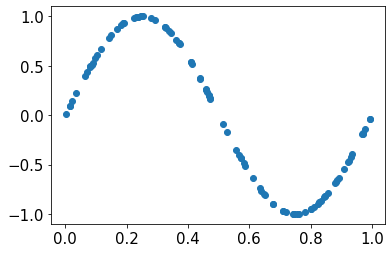

In [101]:
t0_points = sample_t0_points(100, 1).detach()
u_t0 = f_ic_diffusion(t0_points, 2)

plt.figure()
plt.scatter(t0_points[:,1], u_t0)

In [24]:
"""
------------------------------------------------------------------------
                                The TEST
------------------------------------------------------------------------
"""

"""
Parameters
"""
# Diffusion parameters
d = 1
k = 0.1
n = 3

# Network parameters
N_h = [128, 128]

# Training parameters
n_pde_pts = 100   # Number of training points for pde / bc / ic
n_bc_pts = 20
n_ic_pts = 20    
alpha = [5,1,1]       # Relative importance of pde / bc / ic loss
n_iters = 30000     # Number of training iterations
lr = 5e-4          # Learning rate
verbose=n_iters//25

"""
Setup
"""

# Set the random seed for reproducibility
seed = np.random.randint(1e6) # 3141
print('Random seed:', seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Create the network
network = FCN(N_in=d+1, N_out=1, N_h=N_h)

"""
Training Loop
"""
L_pde, L_bc, L_ic, L_train = train_mesh_free(network,
        lambda pts,u: f_pde_diffusion(pts, u, k), f_bc_diffusion, lambda pts: f_ic_diffusion(pts, n), 
        n_pde_pts, n_bc_pts, n_ic_pts, alpha, n_iters, 
        lr, verbose, u_exact=None
    )


Random seed: 201889
Iter 1200/30000, Losses: PDE=3.50e-04 BC=9.29e-03 IC=4.71e-01 TR=4.82e-01
Iter 2400/30000, Losses: PDE=3.83e-03 BC=2.18e-02 IC=2.89e-01 TR=3.30e-01
Iter 3600/30000, Losses: PDE=5.14e-03 BC=4.05e-02 IC=1.52e-01 TR=2.18e-01
Iter 4800/30000, Losses: PDE=5.08e-03 BC=4.84e-02 IC=6.46e-02 TR=1.38e-01
Iter 6000/30000, Losses: PDE=5.47e-03 BC=1.21e-02 IC=3.30e-02 TR=7.24e-02
Iter 7200/30000, Losses: PDE=4.04e-03 BC=1.16e-02 IC=1.36e-02 TR=4.54e-02
Iter 8400/30000, Losses: PDE=2.15e-03 BC=8.76e-03 IC=6.91e-03 TR=2.64e-02
Iter 9600/30000, Losses: PDE=2.53e-03 BC=4.24e-03 IC=4.62e-03 TR=2.15e-02
Iter 10800/30000, Losses: PDE=9.21e-04 BC=2.99e-03 IC=2.65e-03 TR=1.02e-02
Iter 12000/30000, Losses: PDE=1.11e-03 BC=2.14e-03 IC=1.40e-03 TR=9.07e-03
Iter 13200/30000, Losses: PDE=9.81e-04 BC=9.80e-04 IC=1.31e-03 TR=7.20e-03
Iter 14400/30000, Losses: PDE=7.32e-04 BC=1.11e-03 IC=4.14e-04 TR=5.18e-03
Iter 15600/30000, Losses: PDE=1.06e-03 BC=6.35e-04 IC=1.21e-03 TR=7.15e-03
Iter 16800/30

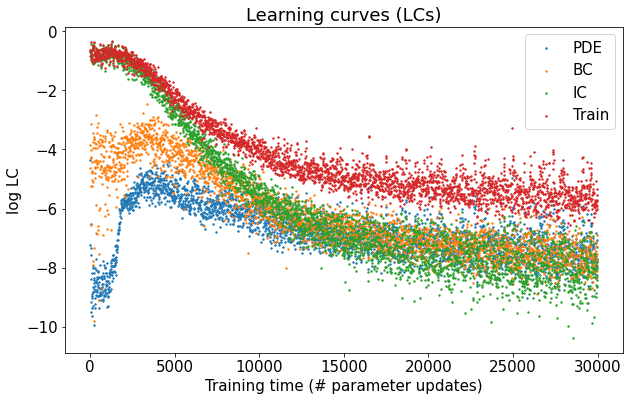

In [26]:
"""
Plot the learning curves
"""
plt.figure(figsize=(10,6))
plt.title('Learning curves (LCs)')
plt.xlabel('Training time (# parameter updates)')
plt.ylabel('log LC')

LCs = [L_pde, L_bc, L_ic, L_train]
labels = ['PDE', 'BC', 'IC', 'Train']
sample_rate = 10
times = sample_rate * np.arange(LCs[0].shape[0] / sample_rate)
for lc,label in zip(LCs, labels):
    plt.scatter(times, np.log(lc[::sample_rate]), label=label, s=2)
plt.legend()
plt.show()

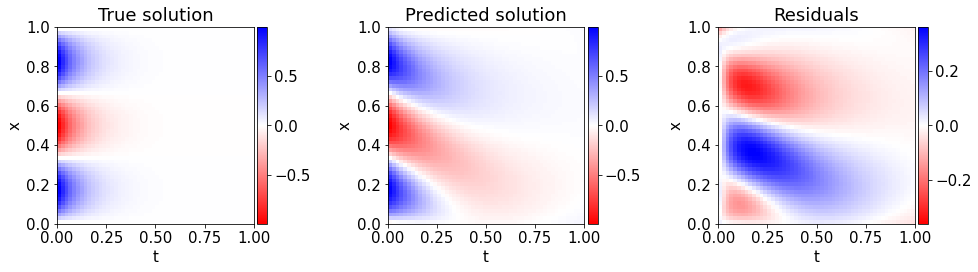

In [27]:
"""
Post training visualization
"""
from mpl_toolkits.axes_grid1 import make_axes_locatable

n_t = 50
n_x = n_t

# Compute the NN's prediction
mesh = generate_mesh(n_t, n_x)
with torch.no_grad():
    u_pred = network(mesh).view(n_t+2,-1)

# Compute the exact solution
T = mesh[:,0].reshape((n_t+2,-1))
X = mesh[:,1].reshape((n_x+2,-1))
u_exact = np.sin(np.pi*n*X)*np.exp((-(np.pi*n)**2)*k*T)

# Heatmap visualization
fig, axs  = plt.subplots(1,3,figsize=(14,4))
for ax in axs:
    ax.set_xlabel('t')
    ax.set_ylabel('x')

vmxx_exact = np.abs(u_exact).max()
vmxx_pred = np.abs(u_pred).max()
vmxx = max(vmxx_pred, vmxx_exact)

# Exact solution
axs[0].set_title('True solution')
im0 = axs[0].imshow(
    u_exact.T, cmap='bwr_r', extent=(0,1,0,1),
    vmin=-vmxx, vmax=vmxx
)
# Predicted solution
axs[1].set_title('Predicted solution')
im1 = axs[1].imshow(
    u_pred.T, cmap='bwr_r', extent=(0,1,0,1),
    vmin=-vmxx, vmax=vmxx
)
# Residuals
residuals = u_exact - u_pred
res_vmxx = np.abs(residuals).max()
axs[2].set_title('Residuals')
im2 = axs[2].imshow(
    residuals.T, cmap='bwr_r', extent=(0,1,0,1),
    vmin=-res_vmxx, vmax=res_vmxx
)

# Colorbors
for i, im in enumerate([im0, im1, im2]):
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()

RMSE: tensor(0.1182)


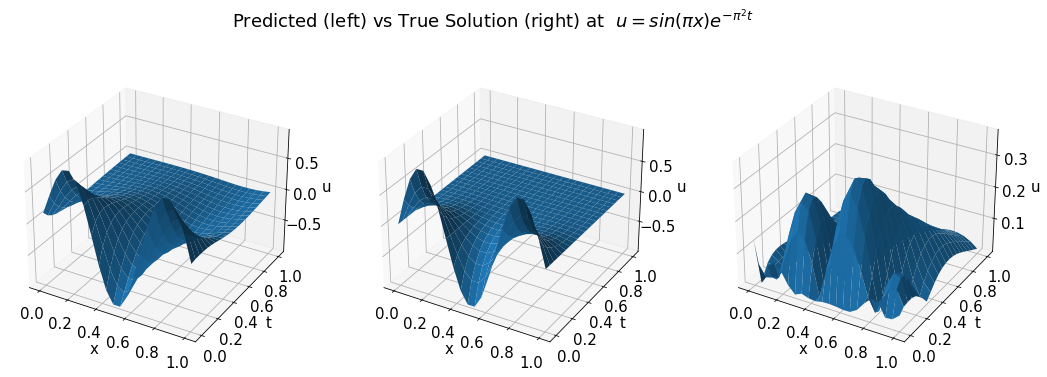

In [16]:
"""
Post training visualization
"""

import matplotlib.gridspec as gridspec

n_t = 20
n_x = n_t

fig = plt.figure(figsize=(18,6))
G = gridspec.GridSpec(1,3)

ax1 = fig.add_subplot(G[0,0], projection='3d')
ax2 = fig.add_subplot(G[0,1], projection='3d')
ax3 = fig.add_subplot(G[0,2], projection='3d')

mesh = generate_mesh(n_t, n_x)
with torch.no_grad():
    pred = network(mesh).view(n_t+2,-1)

T = mesh[:,0].reshape((n_t+2,-1))
X = mesh[:,1].reshape((n_x+2,-1))

u_exact = np.sin(np.pi*n*X)*np.exp((-(np.pi*n)**2)*k*T)

u_res = pred-u_exact
print('RMSE:', np.sqrt((u_res ** 2).mean()))

ax1.plot_surface(X,T,pred)
ax2.plot_surface(X,T,u_exact)
ax3.plot_surface(X,T,np.sqrt(u_res**2))
for ax in [ax1,ax2,ax3]:
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
plt.suptitle(r'Predicted (left) vs True Solution (right) at  $u = sin(\pi x)e^{-\pi^2 t}$')
plt.show()